In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


/Users/samrat-malisetti/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
path = 'lfw'

In [8]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [9]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


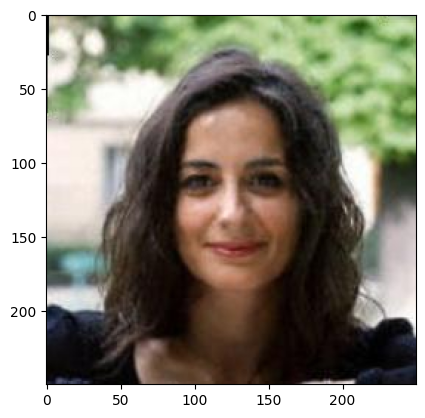

In [10]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

Sample image dimensions: torch.Size([250, 250, 3])


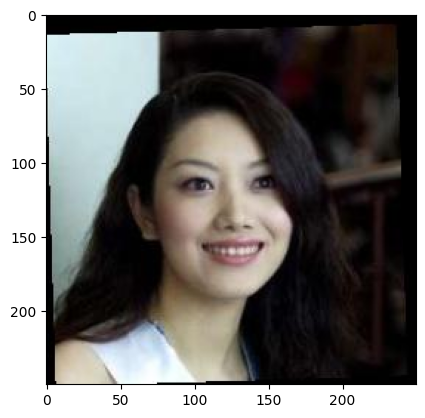

In [11]:
for x, y in dataloader:
    sample_image = x[0].permute(1, 2, 0)
    print("Sample image dimensions:", sample_image.shape)    
    plt.imshow(sample_image)
    plt.show()
    break  

## Explanation of Dimensions:

Number of Channels (C): This dimension represents the color channels in the image -- 3 (Red, Green, Blue).

Image Height (H): It represents the number of pixels in the vertical direction of the image -- (250 pixels).

Image Width (W): It represents the number of pixels in the horizontal direction of the image -- (250 pixels).

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [14]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=1, stride=1, padding=0),  
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(1, stride=1),
        )
        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(16, 3, kernel_size=1, stride=1, padding=0, output_padding=0),  
            nn.BatchNorm2d(3),
            nn.ReLU(True),
            nn.Tanh() 
        )

    def encoder(self, x):
        x_encoded = self.encoder_layers(x)
        return x_encoded

    def decoder(self, x):
        x_decoded = self.decoder_layers(x)
        return x_decoded
    
    def forward(self, x):
        x_encoded = self.encoder(x)

        x_decoded = self.decoder(x_encoded)

        return x_decoded, x_encoded
    
    
autoencoder_model = AE()
    
print(autoencoder_model)

       

AE(
  (encoder_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder_layers): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Tanh()
  )
)


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [15]:
model = AE()

Encoder output shape: torch.Size([32, 16, 250, 250])
Decoder output shape: torch.Size([32, 3, 250, 250])


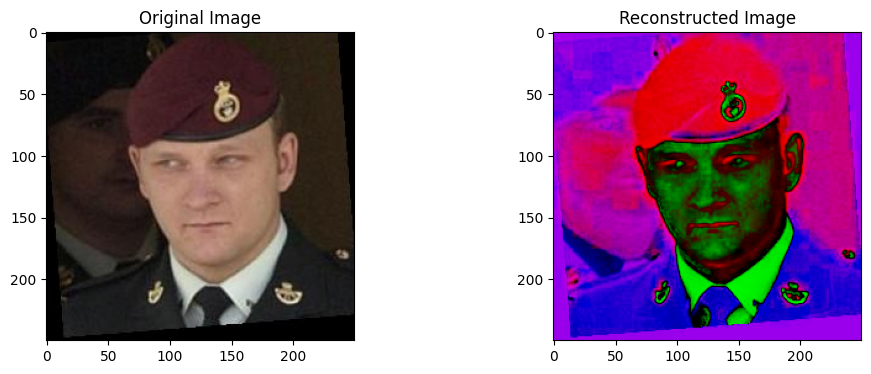

In [16]:
for x, y in dataloader:
    output_decoded, output_encoded = model(x)
    
    print("Encoder output shape:", output_encoded.shape)
    print("Decoder output shape:", output_decoded.shape)
    
    original_image = x[0].permute(1, 2, 0).numpy()
    reconstructed_image = output_decoded[0].detach().permute(1, 2, 0).numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)


    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_image)
    plt.show()
    break

## forward path validation

From the observation of the shapes of the model, decoder shapes that I printed above. The shape of the model(Autoencoder) is equal to decoder output shape. Which states that forward path is working fine. 

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [12]:
from torchsummary import summary
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]              64
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 64, 64]               0
   ConvTranspose2d-5            [-1, 3, 64, 64]              51
       BatchNorm2d-6            [-1, 3, 64, 64]               6
              ReLU-7            [-1, 3, 64, 64]               0
              Tanh-8            [-1, 3, 64, 64]               0
Total params: 153
Trainable params: 153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 2.38
Params size (MB): 0.00
Estimated Total Size (MB): 2.42
----------------------------------------------------------------


In [13]:
optim = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
loss_function =nn.MSELoss()

## Why did I chose MSE ?

MSE loss calculates the average squared difference between corresponding pixel values of the original image and the reconstructed image. The main goal of the autoencoder is to learn the representation of the input data in a lower dimensional space which is also called latent space and then it will rescontruct the input data from this representation. Squaring those differences emphasizes large errors, which makes model sensitive to get the accurate details. MSE has well-defined gradients, facilitating efficient optimization using gradient-based algorithms.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [15]:
num_epochs = 10

In [16]:
for epoch in range(num_epochs):
    total_loss = 0.0

    model.train()

    for x, _ in dataloader:
        output_decoded, _ = model(x)
        loss = loss_function(output_decoded, x)
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')


Epoch [1/10], Loss: 0.0026
Epoch [2/10], Loss: 0.0010
Epoch [3/10], Loss: 0.0009
Epoch [4/10], Loss: 0.0008
Epoch [5/10], Loss: 0.0008
Epoch [6/10], Loss: 0.0007
Epoch [7/10], Loss: 0.0007
Epoch [8/10], Loss: 0.0007
Epoch [9/10], Loss: 0.0006
Epoch [10/10], Loss: 0.0006


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

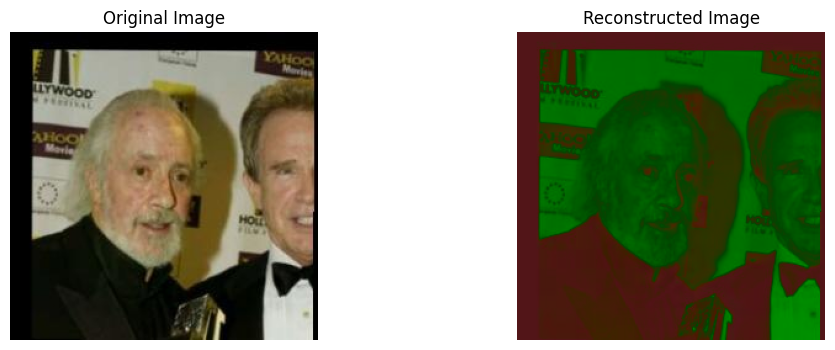

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
model.eval()

random_index = np.random.randint(len(dataloader.dataset))
sample_image, _ = dataloader.dataset[random_index]

sample_image = sample_image.unsqueeze(0)

with torch.no_grad():
    reconstructed_image, _ = model(sample_image)

original_image_np = sample_image.squeeze().permute(1, 2, 0).numpy()
reconstructed_image_np = reconstructed_image.squeeze(-4).permute(1, 2, 0).numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()



##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

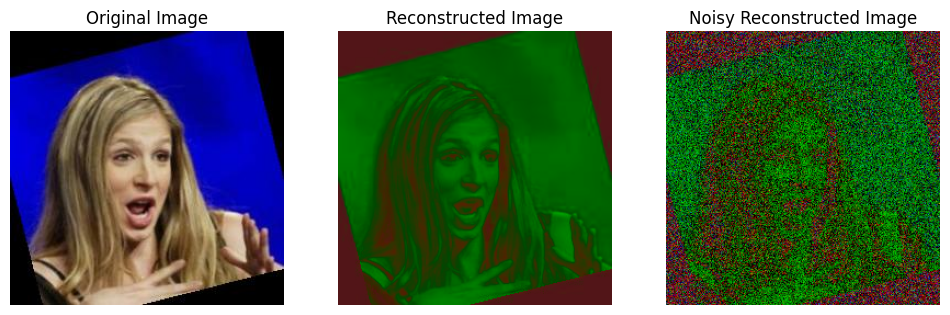

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()

for x, y in dataloader:
    _, latent_representation = model(x)

    noise = torch.randn_like(latent_representation) * 0.2
    noisy_latent_representation = latent_representation + noise

    decoded_output = model.decoder(latent_representation)
    noisy_decoded_output = model.decoder(noisy_latent_representation)

    original_image = x[0].permute(1, 2, 0).numpy()
    reconstructed_image = decoded_output[0].detach().permute(1, 2, 0).numpy()
    noisy_reconstructed_image = noisy_decoded_output[0].detach().permute(1, 2, 0).numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_image)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Noisy Reconstructed Image")
    plt.imshow(noisy_reconstructed_image)
    plt.axis('off')

    plt.show()
    break

## Noise affecting decoded image

Adding noise to the lower dimensional space and subsequently decoding it introduces a regularization effect on the autoencoder. This regularization increases durability by pushing the model to learn more useful characteristics and avoiding the model from becoming overly reliant on specific patterns. Also noise injection promotes the formation of a continuous and structured lower dimensional space, allowing for improved interpolation between distinct data points. Overall, this technique contributes to a strong denoised autoencoder.

## Citations
1. https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/
2. https://medium.com/mlearning-ai/the-magic-of-autoencoders-73162e9bd43f
